# Hypothesis Testing

In [3]:
# Import packages
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib import mlab as ML
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from scipy.stats import poisson
from scipy.stats import lognorm
from decimal import *

# Read in data
df = pd.read_csv('../output.csv')

## Step 0: Looking at the data again
We have to deal with "bad" bins that have a lot of masked voxels:

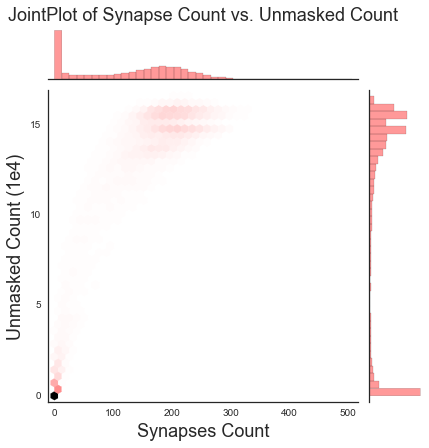

In [50]:
import seaborn as sns
fs = 18
lfs = 14

x = df['synapses']
y = df['unmasked']/1e4

# with sns.plotting_context('notebook', font_scale=1.5), :
with sns.axes_style('white'):
    g = sns.jointplot(x=x, y=y, kind='hex', color='r', 
                  xlim=(x.min()-0.02*np.ptp(x),x.max()+0.02*np.ptp(x)), 
                  ylim=(y.min()-0.02*np.ptp(y),y.max()+0.02*np.ptp(y)),
                  joint_kws={'gridsize':40}, marginal_kws={'bins':40}, stat_func=None);
    plt.gcf().axes[1].set_title("JointPlot of Synapse Count vs. Unmasked Count", fontsize = fs)
    plt.gcf().axes[0].set_xlabel("Synapses Count", fontsize = fs) 
    plt.gcf().axes[0].set_ylabel("Unmasked Count (1e4)", fontsize=fs)
    plt.savefig('./figs/AndrewFigs/jointPlotSynUm.png', format='png', dpi=300)
    plt.show()

Weight each bin by the fraction of unmasked voxels (64x64x48 voxels/bin):

There are 6595 blank bins


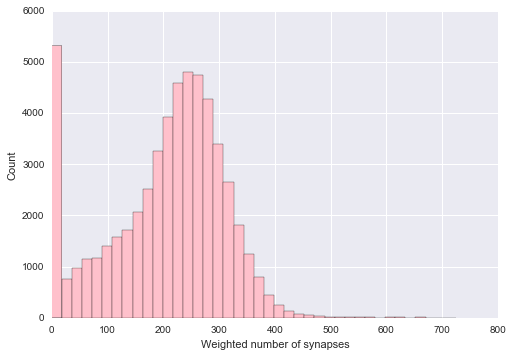

In [5]:
nvox = 64*64*48
df['weighted'] = df['synapses']/df['unmasked']*nvox
syn_wt = df['weighted']

print "There are", df['weighted'].isnull().sum(), "blank bins"

plt.hist(syn_wt, bins = 40, range = (syn_wt.min(), syn_wt.max()),
         color = 'pink');
plt.xlabel('Weighted number of synapses');
plt.ylabel('Count');



Only keep bins with greater than 50% unmasked data:

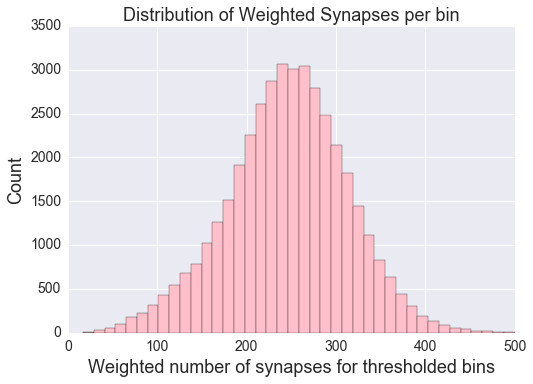

In [7]:
fs = 18
lfs = 14
dfthr = df[df['unmasked']>nvox*0.5] # Thresholded data frame
syn_wt_thresh = dfthr['weighted']


plt.figure()
plt.hist(syn_wt_thresh, bins = 40, range = (syn_wt_thresh.min(), 500),
         color = 'pink');
plt.title('Distribution of Weighted Synapses per bin', fontsize = fs)
plt.xlabel('Weighted number of synapses for thresholded bins',fontsize = fs);
plt.ylabel('Count',fontsize = fs);
plt.tick_params(axis='both', which='major', labelsize=lfs)
plt.savefig('./figs/AndrewFigs/histW.png', format='png', dpi=300)
plt.show()

Look at different Z-slices:

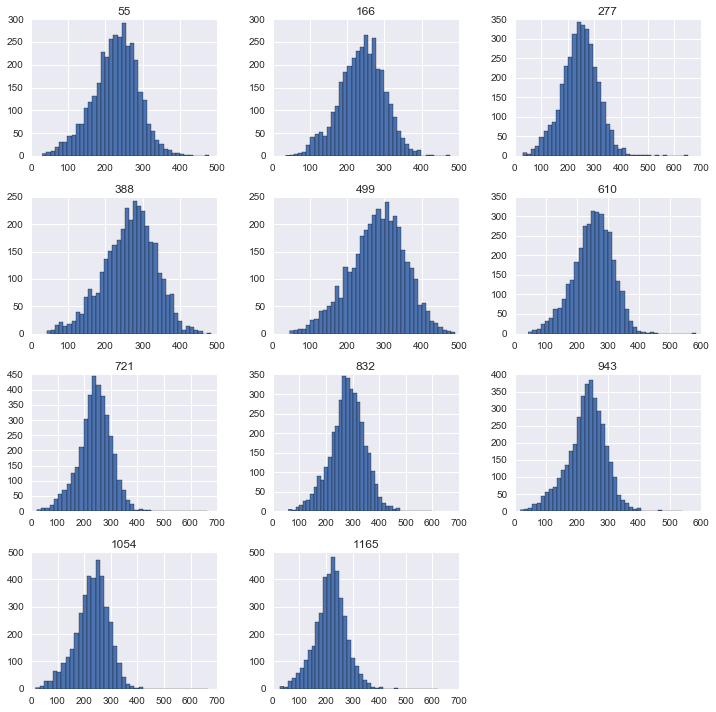

In [5]:
byZ = pd.pivot_table(dfthr, index=['cx','cy'], columns='cz', values='weighted', aggfunc=np.sum);
byZ.hist(bins=40, figsize=(12,12));

## Step 1: Assumptions
* There are 64x64x48 voxels per 3D bin
* $X_i$ is the number of synapses in a 3D bin $i \in \{1, 2, ..., N\}$
* $\lambda$ is average number of synapses per bin
* $N$ is the total number of 3D bins (observations)

## Step 2: Statistical test
$\chi^2 = \sum{\frac{(Observed-Expected)^2}{Expected}}$
* $H_0$: $X_i$ is Poisson (with rate $\lambda$)
* $H_1$: $X_i$ is not Poisson

## Step 3: Test algorithm
* Combine the tails and/or coarsen bins of $X_i$ histogram so that all cells have at least 5 observations (http://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm)
* New histogram $O_j$ is the number of observations (3D bins) with $k$ synapses, where $k \in j^{th}$ cell, $j \in \{1,2,...,m\}$ (m total cells)
* Compute $E_j = \sum_{k \in cell(j)}{N\frac{\lambda^k exp(-\lambda)}{k!}}$, $j \in \{1,2,...,m\}$
* $\chi^2 = \sum_{j=1}^{m}{\frac{(O_j-E_j)^2}{E_j}}$
* Degrees of freedom = $m-2$
* Significance level $\alpha = 0.05$
* If $\chi^2 > \chi^2_{1-\alpha,m-2}$, we reject the null hypothesis.
* Otherwise, there is not sufficient evidence to conclude that $X_i$ is not Poisson.
* We can also test Z-slices individually

## Step 4A: Sample data from null model

In [8]:
alpha = 0.05
S = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 200, 300, 400, 500, 1000, 2000]  # sample size
ite = 100
pow_null = []

for j in S:
    
    m = 10  # bin number
    mu = 3 # lambda of Poisson dist
    n = j  # number of sample (sample size)
    
    p_value = []
    boundary = np.linspace(0, 10, (m + 1))
    cumu_prob = poisson.cdf(boundary, mu = mu)
    exp_prob = []
    for i in range(0, m):
        if i == 0:                
            exp_prob = np.append(exp_prob, cumu_prob[i])
        if i > 0:   
            exp_prob = np.append(exp_prob, cumu_prob[i] - cumu_prob[i - 1])
        if i == (m - 1):
            exp_prob = np.append(exp_prob, 1 - sum(exp_prob))    
            
    exp_freq = exp_prob * n
    expected_values = exp_freq
    
    for iteration in range(0, ite):
            
        sample = np.random.poisson(mu, n)
        
        bin_content = []
        for i in range(0, m + 1):
            bin_content = np.append(bin_content, sum(sample <= boundary[i]))
                                    
        obe_freq = []
        for i in range(0, m + 1):
            if i == 0:
                obe_freq = np.append(obe_freq, bin_content[i])
            if i > 0:
                obe_freq = np.append(obe_freq, bin_content[i] - bin_content[i - 1])
         
        observed_values = obe_freq
         
        test_value = stats.chisquare(observed_values,
                                     f_exp= expected_values)[1]
        
        p_value = np.append(p_value, test_value)
    pow_null = np.append(pow_null, (Decimal(sum(p_value < alpha))) / Decimal(len(range(0, ite))))



## Step 4B: Sample data from alternate model

In [9]:
alpha = 0.05
S = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 200, 300, 400, 500, 1000, 2000]  # sample size
ite = 100
pow_alt = []

for j in S:
    
    m = 10  # number of bins
    mu = 3 # lambda of Poisson dist
    n = j  # number of sample (sample size)
    
    p_value = []
    boundary = np.linspace(0, 10, (m + 1))
    cumu_prob = poisson.cdf(boundary, mu = mu)
    exp_prob = []
    
    for i in range(0, m):
        if i == 0:                
            exp_prob = np.append(exp_prob, cumu_prob[i])
        if i > 0:   
            exp_prob = np.append(exp_prob, cumu_prob[i] - cumu_prob[i - 1])
        if i == (m - 1):
            exp_prob = np.append(exp_prob, 1 - sum(exp_prob))    

    exp_freq = exp_prob * n
            
    for iteration in range(0, ite):
    
        sample = np.random.geometric(p = 0.5, size = n)
        
        bin_content = []
        for i in range(0, m + 1):
            bin_content = np.append(bin_content, sum(sample <= boundary[i]))
                                    
        obe_freq = []
        for i in range(0, m + 1):
            if i == 0:
                obe_freq = np.append(obe_freq, bin_content[i])
            if i > 0:
                obe_freq = np.append(obe_freq, bin_content[i] - bin_content[i - 1])
                 
        observed_values = obe_freq
        expected_values = exp_freq
         
        test_value = stats.chisquare(observed_values,
                                     f_exp= expected_values)[1]
        
        p_value = np.append(p_value, test_value)
    pow_alt = np.append(pow_alt, (Decimal(sum(p_value < alpha))) / Decimal(len(range(0, ite))))
    

## Step 5: Plot power vs N on null set

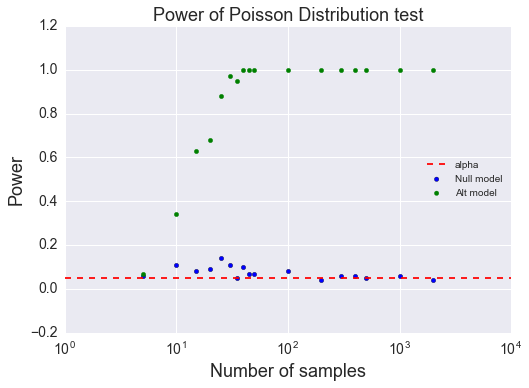

In [51]:
plt.figure()
plt.scatter(S, pow_null, hold = True, label = "Null model")
plt.scatter(S, pow_alt, color = "green", hold=True, label = "Alt model")
plt.xscale("log")
plt.xlabel("Number of samples",fontsize = fs)
plt.ylabel("Power",fontsize = fs)
plt.title("Power of Poisson Distribution test",fontsize = fs)
plt.tick_params(axis='both', which='major', labelsize=lfs)
plt.axhline(alpha, color = "red", linestyle = '--', label = "alpha")
plt.legend(loc = 5)
plt.savefig('./figs/AndrewFigs/poissSim.png', format='png', dpi=300)
plt.show()

## Step 6: Apply to data

histogram the weighted, thresholded synapse counts. The stepSize of 10 was chosen manually after observing different stepSizes. To run a chi-Squared test, each bin should hold at least 5 events. stepSize of 10 was roughly the smallest step that yielded at least 5 events in the "middle" of the distribution. 

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


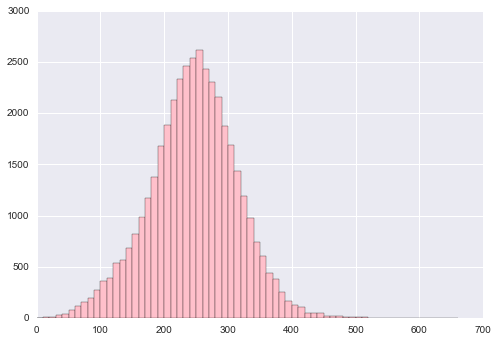

In [28]:
stepSize = 10
boundary = np.arange(0,np.ceil(syn_wt_thresh.max()/stepSize)*stepSize,stepSize);
(observedBin,binEdges,dummy) = plt.hist(syn_wt_thresh, bins = boundary, color = 'pink');

print binEdges
print np.linspace(0, 9, 10)

The observedBin counts include bins at the "tails" with less than 5 events. We summed the "tail" bins together to yield aggregate bins with >= 5 events. Also modified binEdges accordingly and use this to calculate expectedBin

[  15.   35.   45.   55.   65.   75.   85.   95.  105.  115.  125.  135.
  145.  155.  165.  175.  185.  195.  205.  215.  225.  235.  245.  255.
  265.  275.  285.  295.  305.  315.  325.  335.  345.  355.  365.  375.
  385.  395.  405.  415.  425.  435.  445.  455.  465.  475.  485.]
Number of samples:  40522
[  1.32943103e-63   3.68015902e-55   8.42600872e-48   2.63516417e-41
   1.57065524e-35   2.26263681e-30   9.41400032e-26   1.29947180e-21
   6.64991451e-18   1.38179505e-14   1.25792170e-11   5.35104895e-09
   1.12422020e-06   1.22399290e-04   7.20311234e-03   2.37802553e-01
   4.55178175e+00   5.20185612e+01   3.64357557e+02   1.60132955e+03
   4.50991956e+03   8.29542178e+03   1.01379985e+04   8.36175959e+03
   4.72154783e+03   1.84938689e+03   5.08651235e+02   9.93549211e+01
   1.39298748e+01   1.41588292e+00   1.05321396e-01   5.78468635e-03
   2.36581102e-04   7.26265314e-06   1.68630235e-07   2.98273473e-09
   4.04896117e-11   0.00000000e+00   0.00000000e+00   0.00000000e+

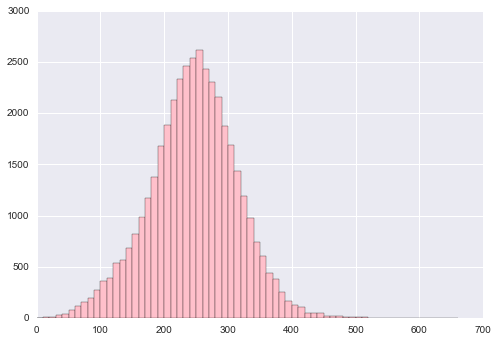

In [33]:
# print np.where(observedBin<5)

# print "based on indicies where observedBin>5, we will hardcode bins 0:1 and bins 47:end"
stepSize = 10
boundary = np.arange(0,np.ceil(syn_wt_thresh.max()/stepSize)*stepSize,stepSize);
(observedBin,binEdges,dummy) = plt.hist(syn_wt_thresh, bins = boundary, color = 'pink');

cumObs = np.cumsum(observedBin)
cumObsRev = np.cumsum(observedBin[::-1])[::-1]

firstIdx = 2
lastIdx =  48

observedBinNoTail = np.concatenate((cumObs[firstIdx:firstIdx+1],observedBin[firstIdx+1:lastIdx],cumObsRev[lastIdx:lastIdx+1]))
# obsBinCent = np.linspace()
# print observedBinNoTail
# print binEdges
binEdges = np.concatenate((binEdges[0:1],binEdges[firstIdx+1:lastIdx+1],np.array([np.inf])))
# print binEdges
binPlot = np.append(np.diff(binEdges[0:len(binEdges)-1]),stepSize)
# print binPlot
binPlot = binPlot/2 + binEdges[0:len(binEdges)-1]
print binPlot
# print binPlot

N = np.size(syn_wt_thresh)
print "Number of samples: ", N

muObs = np.mean(syn_wt_thresh)
#print muObs
cumu_prob = poisson.cdf(binEdges, mu = muObs)
# print cumu_prob
expectedBin = N*np.diff(cumu_prob) 
print expectedBin

Plot observedBinNoTail and expectedBin.  Run the Chi-squared test. obtain p-value

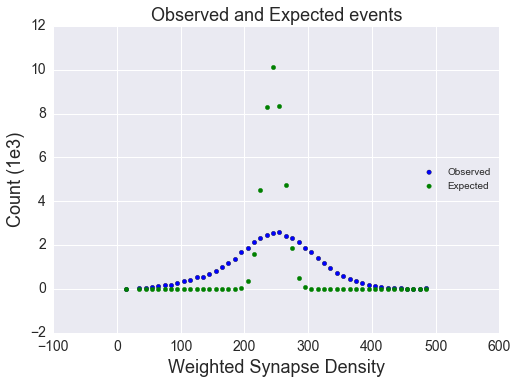

chi-squared statistic:  inf
p-value:  0.0


In [34]:
plt.figure()
plt.scatter(binPlot, observedBinNoTail/1e3, hold = False, label = "Observed")
plt.scatter(binPlot, expectedBin/1e3, color = "green", hold=True, label = "Expected")
plt.legend(loc = 5)
plt.title("Observed and Expected events",fontsize = fs)
plt.xlabel("Weighted Synapse Density",fontsize = fs)
plt.ylabel("Count (1e3)",fontsize = fs)
plt.tick_params(axis='both', which='major', labelsize=lfs)
plt.savefig('./figs/AndrewFigs/chiObsExp.png', format='png', dpi=300)
plt.show()

#print np.square(np.array([1,2]))
#print np.square(observedBin-expectedBin)/expectedBin
#chi2 = np.sum(np.square(observedBin-expectedBin)/expectedBin)
#print chi2

(chi2,p) = stats.chisquare(observedBinNoTail,f_exp=expectedBin,ddof=1)
print "chi-squared statistic: ",chi2
print "p-value: ", p


## Step 7: Interpret

The chi-squared statistic is virtually infinite, which leads to a p-value close to 0, which rejects the null hypothesis. The number of samples is on the order of 10^4. According to Step 5, this number of samples should yield a power of 1.0 if the true distribution was a geometric distribution. Graphically, it seems fairly clear that the distribution is indeed not Poisson. The immediate problem is that the Poisson distribution has only one parameter (the mean), and does not have a second parameter to account for spread. We matched the expected mean with the observed mean, but the spread of the expected vs. spread of the observed distributions are clearly different. We should retry this with a Gaussian or log-normal distribution. Will do this in the future. 